In [22]:
!pip install torchview

In [23]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import numpy as np
import os
import time
import graphviz
from torchview import draw_graph
from matplotlib import pyplot as plt

#Загрузка данных

In [24]:
PATH = os.getcwd()
NORM_PARAMS = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
BATCH_SIZE = 256

In [25]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*NORM_PARAMS, inplace=True)
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*NORM_PARAMS)
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root = PATH, train = True, download = True,
    transform = train_transforms
)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = BATCH_SIZE, shuffle = True
)

test_dataset = torchvision.datasets.CIFAR10(
    root = PATH, train = False, download = True,
    transform = test_transforms
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = BATCH_SIZE, shuffle = False
)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
output_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"Output classes: {output_classes}")

Output names: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### Проверка корректности загрузки данных

Train data samples:


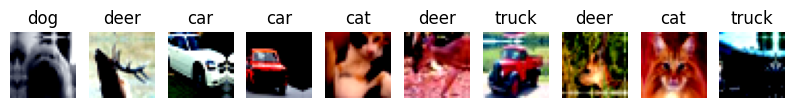

Test data samples:


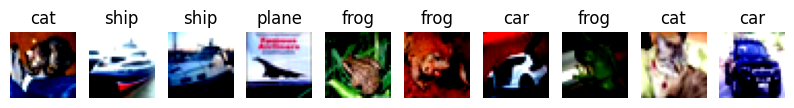

In [27]:
def show_image_sample(loader, title):
    print(f"{title}:")
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, 10, figsize=(10, 5))
    for ax, image, label in zip(axes, images, labels):
        image = image.permute(1, 2, 0)
        image = image * torch.tensor(NORM_PARAMS[0]) + torch.tensor(NORM_PARAMS[1])
        image = image.clamp(0, 1)
        ax.set_title(output_classes[label])
        ax.imshow(image)
        ax.axis("off")
    plt.show()

show_image_sample(train_data_loader, 'Train data samples')
show_image_sample(test_data_loader, 'Test data samples')

In [29]:
print(f"x_train dimension: {train_dataset.data.shape}")
print(f"y_train dimension: {len(train_dataset.targets)}")
print(f"x_test dimension: {test_dataset.data.shape}")
print(f"y_test dimension: {len(test_dataset.targets)}")

x_train dimension: (50000, 32, 32, 3)
y_train dimension: 50000
x_test dimension: (10000, 32, 32, 3)
y_test dimension: 10000


# Построение архитектуры сверточной сети

In [56]:
class ConvolutionNeuralNetwork(torch.nn.Module):
  def __init__(self):
      super(ConvolutionNeuralNetwork, self).__init__()
      self.conv1 = self.make_layer(3, 64)
      self.conv_and_pool_1 = torch.nn.Sequential(
          self.make_layer(64, 128),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.res1 = torch.nn.Sequential(
          self.make_layer(128, 128),
          self.make_layer(128, 128)
      )
      self.conv_and_pool_2 = torch.nn.Sequential(
          self.make_layer(128, 256),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.conv_and_pool_3 = torch.nn.Sequential(
          self.make_layer(256, 512),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.res2 = torch.nn.Sequential(
          self.make_layer(512, 512),
          self.make_layer(512, 512)
      )
      self.final_pool = torch.nn.MaxPool2d(kernel_size=4)
      self.dense = torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Dropout(0.2),
          torch.nn.Linear(512, 10)
      )

  def make_layer(self, input_channels, output_channels):
    return torch.nn.Sequential(
        torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(output_channels),
        torch.nn.ReLU(inplace=True)
    )

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv_and_pool_1(out)
    out = self.res1(out) + out
    out = self.conv_and_pool_2(out)
    out = self.conv_and_pool_3(out)
    out = self.res2(out) + out
    out = self.final_pool(out)
    out = self.dense(out)
    return out

  def accuracy(self, outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

  def epoch_acc(self, accuracies):
    return torch.stack(accuracies).mean()

  def epoch_loss(self, losses):
    return torch.stack(losses).mean()


  def train(self, data_loader, epochs, loss_function, optimizer, device):
    print ("Train started")
    start_time = time.time()
    for epoch in range(epochs):
      start_epoch = time.time()
      accuracies = []
      losses = []
      for i, (images, labels) in enumerate(data_loader):
          images = images.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = self(images)
          loss = loss_function(outputs, labels)
          acc = self.accuracy(outputs, labels)

          losses.append(loss)
          accuracies.append(acc)

          loss.backward()
          optimizer.step()
      total_time_epoch = time.time() - start_epoch
      print(f"Epoch[{epoch + 1}/{EPOCHS_NUMBER}]: Loss = {self.epoch_loss(losses):.4f}, Train accuracy = {self.epoch_acc(accuracies):.4f}, Time epoch = {total_time_epoch:.2f} sec.")
    total_time = time.time() - start_time
    print("Train ended")
    print(f"Total train time: {total_time:.2f} sec.")

  def get_loss(self, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = self(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

  def get_accuracy(self, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = self(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

  def validate(self, data_loader, device):
    print("Validation model on test data")
    test_loss = self.get_loss(data_loader, device)
    test_accuracy = self.get_accuracy(data_loader, device)
    print(f"Test Loss = {test_loss:.4f}, Test accuracy = {test_accuracy:.4f}")

## Визуализация архитектуры

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (f"Using device: {device}")

Using device: cuda


In [58]:
cnn_model = ConvolutionNeuralNetwork().to(device)
cnn_model

ConvolutionNeuralNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_and_pool_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affin

In [59]:
from torchsummary import summary
summary(cnn_model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

# Обучение модели

 Гиперпараметры

In [60]:
LEARNING_RATE = 0.001
EPOCHS_NUMBER = 25

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = LEARNING_RATE)

In [61]:
cnn_model.train(train_data_loader, EPOCHS_NUMBER, loss_function, optimizer, device)

Train started
Epoch[1/25]: Loss = 1.3923, Train accuracy = 0.5075, Time epoch = 39.76 sec.
Epoch[2/25]: Loss = 0.8768, Train accuracy = 0.6911, Time epoch = 39.66 sec.
Epoch[3/25]: Loss = 0.6927, Train accuracy = 0.7595, Time epoch = 40.07 sec.
Epoch[4/25]: Loss = 0.5821, Train accuracy = 0.7982, Time epoch = 39.26 sec.
Epoch[5/25]: Loss = 0.5073, Train accuracy = 0.8246, Time epoch = 39.35 sec.
Epoch[6/25]: Loss = 0.4476, Train accuracy = 0.8460, Time epoch = 39.39 sec.
Epoch[7/25]: Loss = 0.4109, Train accuracy = 0.8582, Time epoch = 39.11 sec.
Epoch[8/25]: Loss = 0.3721, Train accuracy = 0.8716, Time epoch = 39.11 sec.
Epoch[9/25]: Loss = 0.3434, Train accuracy = 0.8818, Time epoch = 38.63 sec.
Epoch[10/25]: Loss = 0.3156, Train accuracy = 0.8896, Time epoch = 38.72 sec.
Epoch[11/25]: Loss = 0.2899, Train accuracy = 0.9003, Time epoch = 39.28 sec.
Epoch[12/25]: Loss = 0.2742, Train accuracy = 0.9046, Time epoch = 39.47 sec.
Epoch[13/25]: Loss = 0.2524, Train accuracy = 0.9123, Time 

# Тестирование модели

In [62]:
cnn_model.validate(test_data_loader, device)

Validation model on test data
Test Loss = 0.0013, Test accuracy = 0.9073
